<a href="https://colab.research.google.com/github/dramfin/Formula-One-Driver-Rankers/blob/main/Formula_One_Driver_Rankers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Formula 1 Position Predictor*

The scope of this project is to predict the **final race positions** of the drivers on a race by races, through the deployment of feature engineering and XGBRanker.

In [124]:
pip install fastf1

In [125]:
import fastf1 as ff1
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, ndcg_score

In [126]:
import os

cache_dir = 'f1cache'
# Create the cache directory if it doesn't exist
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

ff1.Cache.enable_cache(cache_dir)

In [127]:
#Shows list of Available races to predict from.

events = ff1.get_event_schedule(2023)

races_info = events[['RoundNumber', 'Country', 'Location', 'OfficialEventName', 'EventDate']]

display(races_info)

,RoundNumber,Country,Location,OfficialEventName,EventDate
0,0,Bahrain,Sakhir,FORMULA 1 ARAMCO PRE-SEASON TESTING 2023,2023-02-25
1,1,Bahrain,Sakhir,FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2023,2023-03-05
2,2,Saudi Arabia,Jeddah,FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2023,2023-03-19
3,3,Australia,Melbourne,FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2023,2023-04-02
4,4,Azerbaijan,Baku,FORMULA 1 AZERBAIJAN GRAND PRIX 2023,2023-04-30
5,5,United States,Miami,FORMULA 1 CRYPTO.COM MIAMI GRAND PRIX 2023,2023-05-07
6,6,Monaco,Monaco,FORMULA 1 GRAND PRIX DE MONACO 2023,2023-05-28
7,7,Spain,Barcelona,FORMULA 1 AWS GRAN PREMIO DE ESPAÑA 2023,2023-06-04
8,8,Canada,Montréal,FORMULA 1 PIRELLI GRAND PRIX DU CANADA 2023,2023-06-18
9,9,Austria,Spielberg,FORMULA 1 ROLEX GROSSER PREIS VON ÖSTERREICH 2023,2023-07-02


In [128]:
#FastF1 Call Session (Race) Intial Data Pull

year = 2023
race_id = 2
race_type = 'R'

race = ff1.get_session(year, race_id, race_type)

#race = ff1.get_session(YEAR, 'RACE_ID', 'TYPE')

race.load()

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.0]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

In [129]:
df = race.laps

#Use When Needed

#print(df.head(10))

print(df.columns.values)

print(df.shape)

['Time' 'Driver' 'DriverNumber' 'LapTime' 'LapNumber' 'Stint' 'PitOutTime'
 'PitInTime' 'Sector1Time' 'Sector2Time' 'Sector3Time'
 'Sector1SessionTime' 'Sector2SessionTime' 'Sector3SessionTime' 'SpeedI1'
 'SpeedI2' 'SpeedFL' 'SpeedST' 'IsPersonalBest' 'Compound' 'TyreLife'
 'FreshTyre' 'Team' 'LapStartTime' 'LapStartDate' 'TrackStatus' 'Position'
 'Deleted' 'DeletedReason' 'FastF1Generated' 'IsAccurate']
(943, 31)


In [130]:
#Initial Data Clean Up Before Feature Engineering

df1 = df[['Driver', 'LapTime', 'LapNumber', 'Stint', 'PitOutTime',
          'PitInTime', 'Compound', 'TyreLife', 'FreshTyre', 'Team', 'Position', 'Deleted', 'IsAccurate',
          'Sector1Time', 'Sector2Time', 'Sector3Time', 'SpeedST', 'SpeedFL']].copy() # Include sector time columns

# Pit Stops Flags
df1['pit_in_lap'] = df1['PitInTime'].notna()
df1['pit_out_lap'] = df1['PitOutTime'].notna()

# Drop the original PitTime columns
df1 = df1.drop(['PitOutTime', 'PitInTime'], axis=1)

#Clean Data From Inaccurate Data
df2 = df1[(df1['IsAccurate']) | (df1['pit_in_lap']) | (df1['pit_out_lap'])]
df2 =df2[~df2['Deleted']]
df2 = df2.drop(['Deleted'], axis=1)

#Check Up on Current Data
print(df2.head(10))
print(df2.columns.values)
print(df2.shape)

#Sum of Out and In Laps should equal the N of False Accurate Laps
total_pit_stops = df2['pit_in_lap'].sum() + df2['pit_out_lap'].sum()

# Count the number of laps that are NOT accurate.
inaccurate_count = (~df2['IsAccurate']).sum()

# Compare the two counts and print the result.
result = total_pit_stops == inaccurate_count
print(f"Total Pit Stops: {total_pit_stops}")
print(f"Inaccurate Laps: {inaccurate_count}")
print(f"Are they equal? {result}")

   Driver                LapTime  LapNumber  Stint Compound  TyreLife  \
1     VER 0 days 00:01:37.680000        2.0    1.0   MEDIUM       2.0   
2     VER 0 days 00:01:36.526000        3.0    1.0   MEDIUM       3.0   
3     VER 0 days 00:01:36.503000        4.0    1.0   MEDIUM       4.0   
5     VER 0 days 00:01:35.840000        6.0    1.0   MEDIUM       6.0   
6     VER 0 days 00:01:35.687000        7.0    1.0   MEDIUM       7.0   
7     VER 0 days 00:01:35.129000        8.0    1.0   MEDIUM       8.0   
8     VER 0 days 00:01:35.561000        9.0    1.0   MEDIUM       9.0   
9     VER 0 days 00:01:35.443000       10.0    1.0   MEDIUM      10.0   
10    VER 0 days 00:01:35.306000       11.0    1.0   MEDIUM      11.0   
11    VER 0 days 00:01:34.848000       12.0    1.0   MEDIUM      12.0   

    FreshTyre             Team  Position  IsAccurate            Sector1Time  \
1        True  Red Bull Racing      13.0        True 0 days 00:00:36.595000   
2        True  Red Bull Racing      13

In [131]:
#Feature Engineering Section

#Average Lap Time per Driver

df3 = df2.copy()

avg_lap_time = df3.groupby('Driver')['LapTime'].mean().reset_index(name='avg_lap_time')

print(avg_lap_time)

   Driver              avg_lap_time
0     ALB    0 days 00:01:37.156900
1     ALO    0 days 00:01:34.793000
2     BOT 0 days 00:01:37.863133333
3     DEV 0 days 00:01:37.275702127
4     GAS 0 days 00:01:35.581733333
5     HAM 0 days 00:01:35.528851063
6     HUL 0 days 00:01:35.989181818
7     LEC    0 days 00:01:35.333750
8     MAG 0 days 00:01:35.757906976
9     NOR 0 days 00:01:37.952586956
10    OCO 0 days 00:01:35.807978260
11    PER 0 days 00:01:34.214478260
12    PIA 0 days 00:01:36.570422222
13    RUS 0 days 00:01:35.086063829
14    SAI 0 days 00:01:34.593886363
15    SAR 0 days 00:01:37.931369565
16    STR 0 days 00:01:37.254928571
17    TSU    0 days 00:01:36.803000
18    VER 0 days 00:01:34.742266666
19    ZHO 0 days 00:01:37.783826086


In [132]:
#Fastest Lap per Driver

best_lap_time = df3.groupby('Driver')['LapTime'].min().reset_index(name='best_lap_time')

print(best_lap_time)

   Driver          best_lap_time
0     ALB 0 days 00:01:35.567000
1     ALO 0 days 00:01:32.240000
2     BOT 0 days 00:01:34.384000
3     DEV 0 days 00:01:33.609000
4     GAS 0 days 00:01:33.392000
5     HAM 0 days 00:01:32.941000
6     HUL 0 days 00:01:33.780000
7     LEC 0 days 00:01:33.056000
8     MAG 0 days 00:01:33.374000
9     NOR 0 days 00:01:34.122000
10    OCO 0 days 00:01:33.222000
11    PER 0 days 00:01:32.188000
12    PIA 0 days 00:01:34.287000
13    RUS 0 days 00:01:32.433000
14    SAI 0 days 00:01:32.822000
15    SAR 0 days 00:01:34.469000
16    STR 0 days 00:01:35.140000
17    TSU 0 days 00:01:33.931000
18    VER 0 days 00:01:31.906000
19    ZHO 0 days 00:01:33.894000


In [133]:
#Count of Pit Ins per Driver

pit_stop_count = df2.groupby('Driver')['pit_in_lap'].sum().reset_index(name='pit_stop_count')

print(pit_stop_count)

   Driver  pit_stop_count
0     ALB               2
1     ALO               1
2     BOT               3
3     DEV               1
4     GAS               1
5     HAM               1
6     HUL               1
7     LEC               1
8     MAG               1
9     NOR               2
10    OCO               1
11    PER               1
12    PIA               1
13    RUS               1
14    SAI               1
15    SAR               1
16    STR               1
17    TSU               1
18    VER               1
19    ZHO               2


In [134]:
#Average Tyre Life per Stint

avg_tyre_life = df2.groupby(['Driver', 'Stint'])['TyreLife'].mean().reset_index()
avg_tyre_life_per_driver = avg_tyre_life.groupby('Driver')['TyreLife'].mean().reset_index(name='avg_tyre_life_per_stint')

print(avg_tyre_life_per_driver)

   Driver  avg_tyre_life_per_stint
0     ALB                 7.828571
1     ALO                13.983871
2     BOT                 6.968750
3     DEV                13.717742
4     GAS                14.125000
5     HAM                13.483871
6     HUL                13.825397
7     LEC                14.068966
8     MAG                14.015766
9     NOR                 8.744444
10    OCO                13.951613
11    PER                13.450000
12    PIA                13.147727
13    RUS                13.483871
14    SAI                14.500000
15    SAR                13.417204
16    STR                 5.045455
17    TSU                13.717742
18    VER                13.606250
19    ZHO                 9.188889


In [135]:
# Best vs Avg Sector Time Difference

sector_times = df3[['Driver', 'Sector1Time', 'Sector2Time', 'Sector3Time']].copy()

# Best and average per sector
best = sector_times.groupby('Driver')[['Sector1Time', 'Sector2Time', 'Sector3Time']].min()
avg = sector_times.groupby('Driver')[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean()

# Delta (average - best)
sector_delta = (avg - best).reset_index()
sector_delta['avg_sector_delta'] = sector_delta[['Sector1Time', 'Sector2Time', 'Sector3Time']].mean(axis=1)
sector_delta = sector_delta[['Driver', 'avg_sector_delta']]

print(sector_delta.sort_values('avg_sector_delta'))

   Driver          avg_sector_delta
14    SAI 0 days 00:00:00.612628787
4     GAS 0 days 00:00:00.731911110
6     HUL 0 days 00:00:00.761060605
16    STR 0 days 00:00:00.773642856
7     LEC 0 days 00:00:00.775916666
10    OCO 0 days 00:00:00.861992753
12    PIA 0 days 00:00:00.863430134
8     MAG 0 days 00:00:00.886302325
17    TSU 0 days 00:00:00.989999999
15    SAR 0 days 00:00:01.224123188
3     DEV 0 days 00:00:01.248567375
9     NOR 0 days 00:00:01.289528985
5     HAM 0 days 00:00:01.363638888
11    PER 0 days 00:00:01.402191489
19    ZHO 0 days 00:00:01.410608695
13    RUS 0 days 00:00:01.458368055
1     ALO 0 days 00:00:01.471576388
18    VER 0 days 00:00:01.500905796
2     BOT 0 days 00:00:01.546847825
0     ALB 0 days 00:00:02.305363636


In [136]:
#Sequence of Tire Compounds

compound_sequence = df2.groupby(['Driver', 'Stint'])['Compound'].first().reset_index()
tyre_strategy_profile = compound_sequence.groupby('Driver')['Compound'].apply(list).reset_index(name='tyre_strategy_profile')

print(tyre_strategy_profile)

   Driver         tyre_strategy_profile
0     ALB                [MEDIUM, HARD]
1     ALO                [MEDIUM, HARD]
2     BOT  [MEDIUM, HARD, MEDIUM, SOFT]
3     DEV                [MEDIUM, HARD]
4     GAS                [MEDIUM, HARD]
5     HAM                [HARD, MEDIUM]
6     HUL                [MEDIUM, HARD]
7     LEC                  [SOFT, HARD]
8     MAG                [MEDIUM, HARD]
9     NOR          [SOFT, HARD, MEDIUM]
10    OCO                [MEDIUM, HARD]
11    PER                [MEDIUM, HARD]
12    PIA                [MEDIUM, HARD]
13    RUS                [MEDIUM, HARD]
14    SAI                [MEDIUM, HARD]
15    SAR                [HARD, MEDIUM]
16    STR                [MEDIUM, HARD]
17    TSU                [MEDIUM, HARD]
18    VER                [MEDIUM, HARD]
19    ZHO        [MEDIUM, HARD, MEDIUM]


In [137]:
# Average of Speed Traps

top_speed = df3.groupby('Driver')[['SpeedFL', 'SpeedST']].mean().reset_index()
top_speed['top_speed_metric'] = top_speed[['SpeedFL', 'SpeedST']].mean(axis=1)
top_speed = top_speed[['Driver', 'top_speed_metric']]

print(top_speed)

   Driver  top_speed_metric
0     ALB        301.393182
1     ALO        293.901152
2     BOT        294.077604
3     DEV        300.740518
4     GAS        299.025253
5     HAM        296.546543
6     HUL        305.459567
7     LEC        302.670719
8     MAG        305.619601
9     NOR        301.876976
10    OCO        295.190821
11    PER        299.494218
12    PIA        299.965909
13    RUS        293.447252
14    SAI        302.328753
15    SAR        304.159903
16    STR        298.497253
17    TSU        298.114709
18    VER        301.350966
19    ZHO        299.856719


In [138]:
#Driver Form: Position, Trend, Pace, Momentum

# Pace trend: linear regression over lap time vs lap number per driver
from sklearn.linear_model import LinearRegression

def compute_driver_form(group):
    if len(group) < 5:
        return pd.Series({'form_trend': None})
    # LapTime is already in seconds from previous steps
    X = group['LapNumber'].values.reshape(-1, 1)
    y = group['LapTime']
    model = LinearRegression().fit(X, y)
    return pd.Series({'form_trend': model.coef_[0]})  # Positive = getting slower

driver_form = df3.groupby('Driver').apply(compute_driver_form).reset_index()

# Fill NaN values in form_trend with -1
driver_form['form_trend'] = driver_form['form_trend'].fillna(-1)

print(driver_form.sort_values('form_trend'))

   Driver    form_trend
0     ALB -1.332560e+17
9     NOR -1.608712e+08
19    ZHO -1.503418e+08
3     DEV -1.332524e+08
15    SAR -1.329284e+08
12    PIA -1.274004e+08
17    TSU -1.131399e+08
8     MAG -1.023265e+08
6     HUL -9.720663e+07
10    OCO -9.622537e+07
4     GAS -9.352691e+07
7     LEC -8.190226e+07
14    SAI -6.935549e+07
16    STR  4.400135e+08
11    PER  6.593996e+15
5     HAM  6.731009e+15
13    RUS  6.731009e+15
1     ALO  6.731009e+15
18    VER  7.369349e+15
2     BOT  7.834774e+15


In [139]:
#Merge Aggregated Data Features into a Final DF Part 1

from functools import reduce

dfs = [avg_lap_time, best_lap_time, pit_stop_count, avg_tyre_life_per_driver,
       sector_delta, tyre_strategy_profile, top_speed, driver_form]

final_features = reduce(lambda left, right: pd.merge(left, right, on='Driver', how='outer'), dfs)

print(dfs)

[   Driver              avg_lap_time
0     ALB    0 days 00:01:37.156900
1     ALO    0 days 00:01:34.793000
2     BOT 0 days 00:01:37.863133333
3     DEV 0 days 00:01:37.275702127
4     GAS 0 days 00:01:35.581733333
5     HAM 0 days 00:01:35.528851063
6     HUL 0 days 00:01:35.989181818
7     LEC    0 days 00:01:35.333750
8     MAG 0 days 00:01:35.757906976
9     NOR 0 days 00:01:37.952586956
10    OCO 0 days 00:01:35.807978260
11    PER 0 days 00:01:34.214478260
12    PIA 0 days 00:01:36.570422222
13    RUS 0 days 00:01:35.086063829
14    SAI 0 days 00:01:34.593886363
15    SAR 0 days 00:01:37.931369565
16    STR 0 days 00:01:37.254928571
17    TSU    0 days 00:01:36.803000
18    VER 0 days 00:01:34.742266666
19    ZHO 0 days 00:01:37.783826086,    Driver          best_lap_time
0     ALB 0 days 00:01:35.567000
1     ALO 0 days 00:01:32.240000
2     BOT 0 days 00:01:34.384000
3     DEV 0 days 00:01:33.609000
4     GAS 0 days 00:01:33.392000
5     HAM 0 days 00:01:32.941000
6     HUL 0

In [140]:
#Merge Aggregated Data Features into a Final DF Part 2

df_final = pd.merge(df2, final_features, on='Driver', how='left')

# Display the head of the final DataFrame
display(df_final.head())

print(df_final.columns.values)
print(df_final.shape)

,Driver,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,Team,Position,IsAccurate,...,pit_in_lap,pit_out_lap,avg_lap_time,best_lap_time,pit_stop_count,avg_tyre_life_per_stint,avg_sector_delta,tyre_strategy_profile,top_speed_metric,form_trend
0,VER,0 days 00:01:37.680000,2.0,1.0,MEDIUM,2.0,True,Red Bull Racing,13.0,True,...,False,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15
1,VER,0 days 00:01:36.526000,3.0,1.0,MEDIUM,3.0,True,Red Bull Racing,13.0,True,...,False,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15
2,VER,0 days 00:01:36.503000,4.0,1.0,MEDIUM,4.0,True,Red Bull Racing,12.0,True,...,False,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15
3,VER,0 days 00:01:35.840000,6.0,1.0,MEDIUM,6.0,True,Red Bull Racing,11.0,True,...,False,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15
4,VER,0 days 00:01:35.687000,7.0,1.0,MEDIUM,7.0,True,Red Bull Racing,11.0,True,...,False,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15


['Driver' 'LapTime' 'LapNumber' 'Stint' 'Compound' 'TyreLife' 'FreshTyre'
 'Team' 'Position' 'IsAccurate' 'Sector1Time' 'Sector2Time' 'Sector3Time'
 'SpeedST' 'SpeedFL' 'pit_in_lap' 'pit_out_lap' 'avg_lap_time'
 'best_lap_time' 'pit_stop_count' 'avg_tyre_life_per_stint'
 'avg_sector_delta' 'tyre_strategy_profile' 'top_speed_metric'
 'form_trend']
(862, 25)


In [141]:
# Get the final race results

race_results = race.results[['Abbreviation', 'Position']].copy()

race_results = race_results.rename(columns={'Position': 'FinalPosition', 'Abbreviation': 'Driver'})


df_final = pd.merge(df_final, race_results, on='Driver', how='left')

# Display the head of the updated df_final DataFrame
display(df_final.head())

print(df_final.columns.values)
print(df_final.shape)

,Driver,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,Team,Position,IsAccurate,...,pit_out_lap,avg_lap_time,best_lap_time,pit_stop_count,avg_tyre_life_per_stint,avg_sector_delta,tyre_strategy_profile,top_speed_metric,form_trend,FinalPosition
0,VER,0 days 00:01:37.680000,2.0,1.0,MEDIUM,2.0,True,Red Bull Racing,13.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
1,VER,0 days 00:01:36.526000,3.0,1.0,MEDIUM,3.0,True,Red Bull Racing,13.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
2,VER,0 days 00:01:36.503000,4.0,1.0,MEDIUM,4.0,True,Red Bull Racing,12.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
3,VER,0 days 00:01:35.840000,6.0,1.0,MEDIUM,6.0,True,Red Bull Racing,11.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
4,VER,0 days 00:01:35.687000,7.0,1.0,MEDIUM,7.0,True,Red Bull Racing,11.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0


['Driver' 'LapTime' 'LapNumber' 'Stint' 'Compound' 'TyreLife' 'FreshTyre'
 'Team' 'Position' 'IsAccurate' 'Sector1Time' 'Sector2Time' 'Sector3Time'
 'SpeedST' 'SpeedFL' 'pit_in_lap' 'pit_out_lap' 'avg_lap_time'
 'best_lap_time' 'pit_stop_count' 'avg_tyre_life_per_stint'
 'avg_sector_delta' 'tyre_strategy_profile' 'top_speed_metric'
 'form_trend' 'FinalPosition']
(862, 26)


In [142]:
#Now All Variables Must Be Enconded Before Training Models

print(df_final.head(1))

  Driver                LapTime  LapNumber  Stint Compound  TyreLife  \
0    VER 0 days 00:01:37.680000        2.0    1.0   MEDIUM       2.0   

   FreshTyre             Team  Position  IsAccurate  ... pit_out_lap  \
0       True  Red Bull Racing      13.0        True  ...       False   

               avg_lap_time          best_lap_time  pit_stop_count  \
0 0 days 00:01:34.742266666 0 days 00:01:31.906000               1   

   avg_tyre_life_per_stint          avg_sector_delta  tyre_strategy_profile  \
0                 13.60625 0 days 00:00:01.500905796         [MEDIUM, HARD]   

  top_speed_metric    form_trend  FinalPosition  
0       301.350966  7.369349e+15            2.0  

[1 rows x 26 columns]


In [143]:
#Non numerical variables in df_final2 must be encoded

from sklearn.preprocessing import LabelEncoder


non_numeric_cols = df_final.select_dtypes(include='object').columns.tolist()

cols_to_exclude = ['FinalPosition', 'LapTime', 'tyre_strategy_profile']
non_numeric_cols = [col for col in non_numeric_cols if col not in cols_to_exclude]

for col in non_numeric_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])

df_final2=df_final.copy()
df_final2.info()
display(df_final2.head(100))

<class 'fastf1.core.Laps'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   Driver                   862 non-null    int64          
 1   LapTime                  854 non-null    timedelta64[ns]
 2   LapNumber                862 non-null    float64        
 3   Stint                    862 non-null    float64        
 4   Compound                 862 non-null    int64          
 5   TyreLife                 862 non-null    float64        
 6   FreshTyre                862 non-null    bool           
 7   Team                     862 non-null    int64          
 8   Position                 862 non-null    float64        
 9   IsAccurate               862 non-null    bool           
 10  Sector1Time              861 non-null    timedelta64[ns]
 11  Sector2Time              862 non-null    timedelta64[ns]
 12  Sector3Time              862 non-

,Driver,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,Team,Position,IsAccurate,...,pit_out_lap,avg_lap_time,best_lap_time,pit_stop_count,avg_tyre_life_per_stint,avg_sector_delta,tyre_strategy_profile,top_speed_metric,form_trend,FinalPosition
0,18,0 days 00:01:37.680000,2.0,1.0,1,2.0,True,8,13.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
1,18,0 days 00:01:36.526000,3.0,1.0,1,3.0,True,8,13.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
2,18,0 days 00:01:36.503000,4.0,1.0,1,4.0,True,8,12.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
3,18,0 days 00:01:35.840000,6.0,1.0,1,6.0,True,8,11.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
4,18,0 days 00:01:35.687000,7.0,1.0,1,7.0,True,8,11.0,True,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,"[MEDIUM, HARD]",301.350966,7.369349e+15,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,11,0 days 00:01:34.621000,6.0,1.0,1,6.0,True,8,1.0,True,...,False,0 days 00:01:34.214478260,0 days 00:01:32.188000,1,13.45000,0 days 00:00:01.402191489,"[MEDIUM, HARD]",299.494218,6.593996e+15,1.0
96,11,0 days 00:01:34.277000,7.0,1.0,1,7.0,True,8,1.0,True,...,False,0 days 00:01:34.214478260,0 days 00:01:32.188000,1,13.45000,0 days 00:00:01.402191489,"[MEDIUM, HARD]",299.494218,6.593996e+15,1.0
97,11,0 days 00:01:34.477000,8.0,1.0,1,8.0,True,8,1.0,True,...,False,0 days 00:01:34.214478260,0 days 00:01:32.188000,1,13.45000,0 days 00:00:01.402191489,"[MEDIUM, HARD]",299.494218,6.593996e+15,1.0
98,11,0 days 00:01:34.255000,9.0,1.0,1,9.0,True,8,1.0,True,...,False,0 days 00:01:34.214478260,0 days 00:01:32.188000,1,13.45000,0 days 00:00:01.402191489,"[MEDIUM, HARD]",299.494218,6.593996e+15,1.0


In [144]:
#Final Variable Clean Ups

df_final2['tyre_strategy_profile'] = df_final2['tyre_strategy_profile'].apply(
    lambda x: ','.join(x) if isinstance(x, list) else x
)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_final2['tyre_strategy_profile'] = le.fit_transform(df_final2['tyre_strategy_profile'])


In [145]:
df_final2 = df_final2.drop('IsAccurate', axis=1)

df_final2.info()
display(df_final2.head())

<class 'fastf1.core.Laps'>
RangeIndex: 862 entries, 0 to 861
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   Driver                   862 non-null    int64          
 1   LapTime                  854 non-null    timedelta64[ns]
 2   LapNumber                862 non-null    float64        
 3   Stint                    862 non-null    float64        
 4   Compound                 862 non-null    int64          
 5   TyreLife                 862 non-null    float64        
 6   FreshTyre                862 non-null    bool           
 7   Team                     862 non-null    int64          
 8   Position                 862 non-null    float64        
 9   Sector1Time              861 non-null    timedelta64[ns]
 10  Sector2Time              862 non-null    timedelta64[ns]
 11  Sector3Time              862 non-null    timedelta64[ns]
 12  SpeedST                  862 non-

,Driver,LapTime,LapNumber,Stint,Compound,TyreLife,FreshTyre,Team,Position,Sector1Time,...,pit_out_lap,avg_lap_time,best_lap_time,pit_stop_count,avg_tyre_life_per_stint,avg_sector_delta,tyre_strategy_profile,top_speed_metric,form_trend,FinalPosition
0,18,0 days 00:01:37.680000,2.0,1.0,1,2.0,True,8,13.0,0 days 00:00:36.595000,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,1,301.350966,7.369349e+15,2.0
1,18,0 days 00:01:36.526000,3.0,1.0,1,3.0,True,8,13.0,0 days 00:00:36.020000,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,1,301.350966,7.369349e+15,2.0
2,18,0 days 00:01:36.503000,4.0,1.0,1,4.0,True,8,12.0,0 days 00:00:36.021000,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,1,301.350966,7.369349e+15,2.0
3,18,0 days 00:01:35.840000,6.0,1.0,1,6.0,True,8,11.0,0 days 00:00:35.547000,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,1,301.350966,7.369349e+15,2.0
4,18,0 days 00:01:35.687000,7.0,1.0,1,7.0,True,8,11.0,0 days 00:00:35.409000,...,False,0 days 00:01:34.742266666,0 days 00:01:31.906000,1,13.60625,0 days 00:00:01.500905796,1,301.350966,7.369349e+15,2.0


In [146]:
agg_funcs = {
    'LapTime': 'mean',
    'Sector1Time': 'mean',
    'Sector2Time': 'mean',
    'Sector3Time': 'mean',
    'avg_lap_time': 'last',
    'best_lap_time': 'min',
    'avg_sector_delta': 'mean',
    'TyreLife': 'mean',
    'top_speed_metric': 'max',
    'form_trend': 'last',
    'pit_stop_count': 'max',
    'avg_tyre_life_per_stint': 'last',
    'SpeedST': 'max',
    'SpeedFL': 'max',
    'Compound': 'last',
    'Team': 'last',
    'FreshTyre': 'last',
    'pit_in_lap': 'sum',
    'pit_out_lap': 'sum',
    'FinalPosition': 'last',
    'tyre_strategy_profile': 'last'
}

df_driver = df_final2.groupby('Driver').agg(agg_funcs).reset_index()

df_driver.head(50)

,Driver,LapTime,Sector1Time,Sector2Time,Sector3Time,avg_lap_time,best_lap_time,avg_sector_delta,TyreLife,top_speed_metric,...,avg_tyre_life_per_stint,SpeedST,SpeedFL,Compound,Team,FreshTyre,pit_in_lap,pit_out_lap,FinalPosition,tyre_strategy_profile
0,0,0 days 00:01:37.156900,0 days 00:00:38.060818181,0 days 00:00:31.386000,0 days 00:00:32.620272727,0 days 00:01:37.156900,0 days 00:01:35.567000,0 days 00:00:02.305363636,8.545455,301.393182,...,7.828571,334.0,313.0,0,9,True,2,1,19.0,1
1,1,0 days 00:01:34.793000,0 days 00:00:35.557312500,0 days 00:00:30.419208333,0 days 00:00:30.678208333,0 days 00:01:34.793000,0 days 00:01:32.240000,0 days 00:00:01.471576388,15.145833,293.901152,...,13.983871,320.0,302.0,0,3,False,1,1,3.0,1
2,2,0 days 00:01:37.863133333,0 days 00:00:37.032586956,0 days 00:00:30.860826086,0 days 00:00:31.128130434,0 days 00:01:37.863133333,0 days 00:01:34.384000,0 days 00:00:01.546847825,7.630435,294.077604,...,6.968750,321.0,304.0,2,0,True,3,3,18.0,3
3,3,0 days 00:01:37.275702127,0 days 00:00:36.154106382,0 days 00:00:30.414744680,0 days 00:00:30.706851063,0 days 00:01:37.275702127,0 days 00:01:33.609000,0 days 00:00:01.248567375,15.063830,300.740518,...,13.717742,330.0,312.0,0,1,True,1,1,14.0,1
4,4,0 days 00:01:35.581733333,0 days 00:00:35.603488888,0 days 00:00:29.962977777,0 days 00:00:30.015266666,0 days 00:01:35.581733333,0 days 00:01:33.392000,0 days 00:00:00.731911110,16.711111,299.025253,...,14.125000,320.0,307.0,0,2,True,1,1,9.0,1
5,5,0 days 00:01:35.528851063,0 days 00:00:35.847666666,0 days 00:00:30.302541666,0 days 00:00:30.730708333,0 days 00:01:35.528851063,0 days 00:01:32.941000,0 days 00:00:01.363638888,14.500000,296.546543,...,13.483871,326.0,307.0,1,7,True,1,1,5.0,0
6,6,0 days 00:01:35.989181818,0 days 00:00:35.898545454,0 days 00:00:29.948090909,0 days 00:00:30.142545454,0 days 00:01:35.989181818,0 days 00:01:33.780000,0 days 00:00:00.761060605,18.318182,305.459567,...,13.825397,336.0,314.0,0,5,True,1,1,12.0,1
7,7,0 days 00:01:35.333750,0 days 00:00:35.330977272,0 days 00:00:29.870977272,0 days 00:00:30.131795454,0 days 00:01:35.333750,0 days 00:01:33.056000,0 days 00:00:00.775916666,15.681818,302.670719,...,14.068966,329.0,310.0,0,4,True,1,1,7.0,4
8,8,0 days 00:01:35.757906976,0 days 00:00:35.703906976,0 days 00:00:29.919604651,0 days 00:00:30.134395348,0 days 00:01:35.757906976,0 days 00:01:33.374000,0 days 00:00:00.886302325,20.395349,305.619601,...,14.015766,336.0,310.0,0,5,True,1,1,10.0,1
9,9,0 days 00:01:37.952586956,0 days 00:00:36.609086956,0 days 00:00:30.583804347,0 days 00:00:30.759695652,0 days 00:01:37.952586956,0 days 00:01:34.122000,0 days 00:00:01.289528985,13.195652,301.876976,...,8.744444,330.0,313.0,1,6,True,2,2,17.0,5


In [147]:
#Split Test and Training Data

df_driver['relevance'] = df_driver['FinalPosition'].max() - df_driver['FinalPosition'] + 1

from sklearn.model_selection import train_test_split
from xgboost import XGBRanker

# Features and target
X = df_driver.drop(columns=['Driver', 'FinalPosition', 'relevance']).fillna(-1).values
y = df_driver['relevance'].values

# Split data
feature_cols = df_driver.drop(columns=['Driver', 'FinalPosition', 'relevance']).fillna(-1).columns
X_df = df_driver[feature_cols].fillna(-1)

#For Visualization on Evaluation Plots
X_train, X_test, y_train, y_test, df_train, df_test = train_test_split(
    X_df, y, df_driver, test_size=0.2, random_state=1
)

group_train = [len(X_train)]
group_test = [len(X_test)]


In [150]:
#XGB Ranker Model

ranker = XGBRanker(
    objective='rank:pairwise',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)

ranker.fit(X_train, y_train, group=group_train)


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None, learning_rate=0.1,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=6, max_leaves=None,
          min_child_weight=None, missing=nan, monotone_constraints=None,
          multi_strategy=None, n_estimators=100, n_jobs=None,
          num_parallel_tree=None, objective='rank:pairwise', ...)

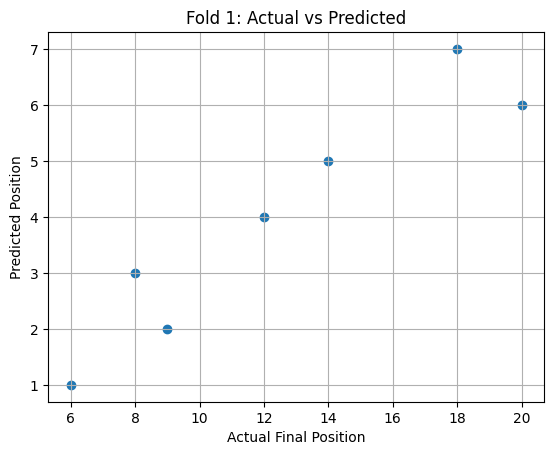

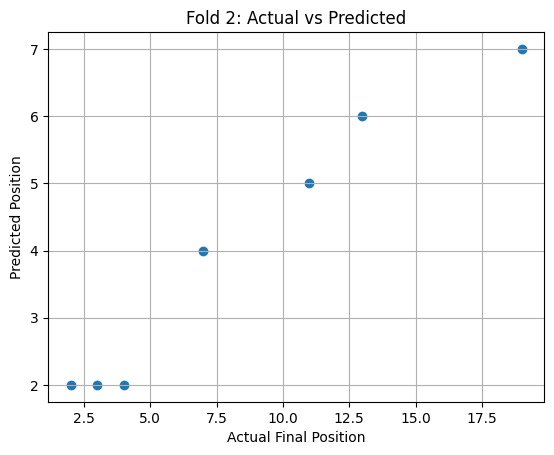

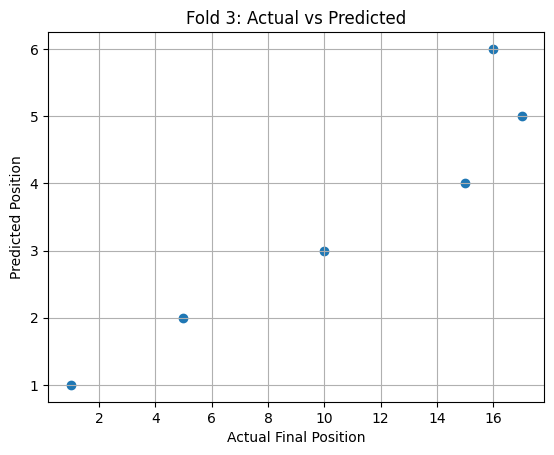

In [151]:
from sklearn.model_selection import KFold
from xgboost import XGBRanker
import matplotlib.pyplot as plt
import pandas as pd

kf = KFold(n_splits=3, shuffle=True, random_state=1)

all_results = []

# Convert timedelta columns to total seconds and drop the object column
df_driver_processed = df_driver.copy()
for col in ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time', 'avg_lap_time', 'best_lap_time', 'avg_sector_delta']:
    df_driver_processed[col] = df_driver_processed[col].dt.total_seconds()

for fold, (train_idx, test_idx) in enumerate(kf.split(df_driver_processed), 1):
    X_train, X_test = df_driver_processed.iloc[train_idx].drop(columns=['Driver', 'FinalPosition', 'relevance']), df_driver_processed.iloc[test_idx].drop(columns=['Driver', 'FinalPosition', 'relevance'])
    y_train, y_test = df_driver_processed['relevance'].iloc[train_idx], df_driver_processed['relevance'].iloc[test_idx]
    df_train, df_test = df_driver_processed.iloc[train_idx], df_driver_processed.iloc[test_idx]

    group_train = [len(X_train)]

    ranker = XGBRanker(
        objective='rank:pairwise',
        learning_rate=0.01,
        n_estimators=100,
        max_depth=6,
        random_state=42
    )

    ranker.fit(X_train, y_train, group=group_train)
    y_pred = ranker.predict(X_test)

    df_test = df_test.copy()
    df_test['pred'] = y_pred
    df_test['predicted_position'] = df_test['pred'].rank(ascending=False)
    df_test['fold'] = fold

    # Store for later analysis
    all_results.append(df_test[['Driver', 'FinalPosition', 'predicted_position', 'fold']])

    # Visualize each fold
    plt.figure()
    plt.scatter(df_test['FinalPosition'], df_test['predicted_position'])
    plt.xlabel("Actual Final Position")
    plt.ylabel("Predicted Position")
    plt.title(f"Fold {fold}: Actual vs Predicted")
    plt.grid(True)
    plt.show()

In [152]:
#NDCG Metric

from sklearn.metrics import ndcg_score
print("NDCG@5:", ndcg_score([y_test], [y_pred], k=5))

NDCG@5: 0.9903559722829828


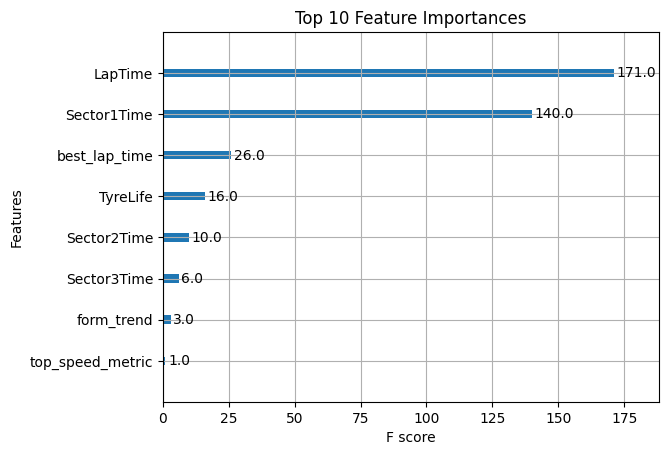

In [153]:
#Rank Feature Importance

import xgboost as xgb
import matplotlib.pyplot as plt

xgb.plot_importance(ranker, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.show()
